##### *Copyright 2020 Google LLC*
*Licensed under the Apache License, Version 2.0 (the "License")*

In [24]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import the required libraries
We have the required dataset in a misleadingly named shared drive folder:

We set the path of the dataset here:

In [25]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [26]:
path = '/content/drive/My Drive/ELEN 6350/6908 Dataset/'

Import all the relevant libraries

In [27]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the training data

We are using a six-class recycling/trash dataset, with each class separated into different folders.

In [29]:
data_dir = os.path.join(path, 'Garbage classification')
# data_dir = '/content/drive/Shareddrives/ELEN 6350/6908 Dataset/Garbage classification'

In [30]:
print(os.getcwd())
os.chdir('/content/drive/My Drive/ELEN 6350/6908 Dataset/')

print("Current directory:", os.getcwd())


/content/drive/.shortcut-targets-by-id/1ZwkGtzXqT581LVQ7k4uaz4vuI_P6pQEq/ELEN 6350/6908 Dataset
Current directory: /content/drive/.shortcut-targets-by-id/1ZwkGtzXqT581LVQ7k4uaz4vuI_P6pQEq/ELEN 6350/6908 Dataset


In [31]:
print(data_dir)
if os.path.exists(data_dir):
    print("Path exists.")
else:
    print("Path does not exist.")

/content/drive/My Drive/ELEN 6350/6908 Dataset/Garbage classification
Path exists.


Next, we use [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to rescale the image data into float values (divide by 255 so the tensor values are between 0 and 1), and call `flow_from_directory()` to create two generators: one for the training dataset and one for the validation dataset. Since the base model is optimized for 224x244 images, we downscale out images as well to 224x224


In [32]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.



On each iteration, these generators provide a batch of images by reading images from disk and processing them to the proper tensor size (224 x 224). The output is a tuple of (images, labels). The shapes are shown here

In [33]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 6))

Now save the class labels to a text file:

In [34]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('garbage_labels.txt', 'w') as f:
  f.write(labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [35]:
!cat garbage_labels.txt

cardboard
glass
metal
paper
plastic
trash

## Building the 6 models

We create 3 models that center around a pre-trained MobileNet V2 model, and 3 customized models wrriten and trained entirely from scratch.


### Create the base model

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

In [36]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Define the base model from the pre-trained MobileNet V2
base_model_MNV2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model_MNV2.trainable = False


### Define the models

We create a 3 models with [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and pass the frozen MobileNet model as the base of the graph, and append additional convolutional, dropout, and dense feedfoward layers so we can set the final output dimension to match the number of classes in our dataset (6 types of classes). We do this for Models A, B and C. For the models D, E, and F, we do this step similarly like in above, but we do not pass in the base pretrained model, but start with an input layer if size (224, 224, 3), and append a series of convolutional + batch norm + pooling layers, before reaching 2 dense feedforward layers at the output.

In [37]:
modelA = tf.keras.Sequential([
  base_model_MNV2,
  tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=6, activation='softmax')
])

In [38]:
modelB = tf.keras.Sequential([
  base_model_MNV2,
  tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units = 64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

In [39]:
modelC = tf.keras.Sequential([
  base_model_MNV2,
  tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 64, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(units = 6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

In [136]:
modelD = tf.keras.Sequential([
  tf.keras.layers.InputLayer(shape = (224, 224, 3)),

  tf.keras.layers.Conv2D(filters=16, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters=32, kernel_size = 5, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters=64, kernel_size = 7, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

In [137]:
modelE = tf.keras.Sequential([
  tf.keras.layers.InputLayer(shape = (224, 224, 3)),

  tf.keras.layers.Conv2D(filters=32, kernel_size = 5, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters=64, kernel_size = 7, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(filters=64, kernel_size = 11, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(filters=64, kernel_size = 15, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

In [138]:
modelF = tf.keras.Sequential([
  tf.keras.layers.InputLayer(shape = (224, 224, 3)),

  tf.keras.layers.Conv2D(filters=16, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(filters=32, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(filters=64, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=64, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters=128, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size = 3, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters=128, kernel_size = 5, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size = 5, activation = 'relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))
])

### Configure the model

Although this method is called `compile()`, it's basically a configuration step that's required before we can start training.

In [139]:
modelA.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelB.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelC.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelD.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelE.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelF.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

We display the layers in the model architecture, for all 6 models

In [140]:
print("Model A Architecture:")
modelA.summary()
print("Model B Architecture:")
modelB.summary()
print("Model C Architecture:")
modelC.summary()
print("Model D Architecture:")
modelD.summary()
print("Model E Architecture:")
modelE.summary()
print("Model F Architecture:")
modelF.summary()

Model A Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 3, 3, 32)       │     1,024,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,283,750 (12.53 MB)

 Trainable params: 3,200,358 (12.21 MB)

 Non-trainable params: 83,392 (325.75 KB)

Model B Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 3, 32)       │     1,024,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,327,654 (12.69 MB)

 Trainable params: 3,244,262 (12.38 MB)

 Non-trainable params: 83,392 (325.75 KB)

Model C Architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 32)       │       163,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 2, 2, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,046 (9.29 MB)

 Trainable params: 2,351,462 (8.97 MB)

 Non-trainable params: 83,584 (326.50 KB)

Model D Architecture:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 107, 107, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 107, 107, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 47, 47, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,448,614 (16.97 MB)

 Trainable params: 4,448,390 (16.97 MB)

 Non-trainable params: 224 (896.00 B)

Model E Architecture:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 220, 220, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 104, 104, 64)   │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 104, 104, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 42, 42, 64)     │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 42, 42, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 7, 7, 64)       │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,558,406 (5.94 MB)

 Trainable params: 1,557,958 (5.94 MB)

 Non-trainable params: 448 (1.75 KB)

Model F Architecture:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 6, 6, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 6, 6, 128)      │           51

 Total params: 1,121,958 (4.28 MB)

 Trainable params: 1,120,326 (4.27 MB)

 Non-trainable params: 1,632 (6.38 KB)

And because the majority of the layers in the models A, B and C is frozen in the base model,  only the last convolution and dense layers are trainable:

In [183]:
print('Number of trainable layers in Model A = {}'.format(len(modelA.trainable_weights)))
print('Number of trainable layers in Model B = {}'.format(len(modelB.trainable_weights)))
print('Number of trainable layers in Model C = {}'.format(len(modelC.trainable_weights)))
print('Number of trainable layers in Model D = {}'.format(len(modelD.trainable_weights)))
print('Number of trainable layers in Model E = {}'.format(len(modelE.trainable_weights)))
print('Number of trainable layers in Model F = {}'.format(len(modelF.trainable_weights)))

Number of trainable layers in Model A = 109
Number of trainable layers in Model B = 113
Number of trainable layers in Model C = 117
Number of trainable layers in Model D = 16
Number of trainable layers in Model E = 20
Number of trainable layers in Model F = 38


## Train the model


We train the model using data provided by the `train_generator` and `val_generator` during the data preprocessing step

In [46]:
historyA = modelA.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 732s 23s/step - accuracy: 0.3707 - loss: 2.6078 - val_accuracy: 0.6004 - val_loss: 1.0424
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 483ms/step - accuracy: 0.6993 - loss: 0.8563 - val_accuracy: 0.6819 - val_loss: 0.9347
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.8102 - loss: 0.5734 - val_accuracy: 0.7038 - val_loss: 0.8277
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.8613 - loss: 0.3848 - val_accuracy: 0.7177 - val_loss: 0.9813
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.9010 - loss: 0.3052 - val_accuracy: 0.7475 - val_loss: 1.0075
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - accuracy: 0.9241 - loss: 0.2033 - val_accuracy: 0.7376 - val_loss: 0.9351
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9493 - loss: 0.1534 - val_accuracy: 0.7356 - val_loss: 1.0202
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.9505 - loss: 0.1336 - val_accur

In [47]:
historyB = modelB.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 748ms/step - accuracy: 0.2739 - loss: 3.0865 - val_accuracy: 0.4970 - val_loss: 2.0822
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.5360 - loss: 1.9858 - val_accuracy: 0.6203 - val_loss: 1.7903
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.6257 - loss: 1.6584 - val_accuracy: 0.6620 - val_loss: 1.4889
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 466ms/step - accuracy: 0.7157 - loss: 1.2705 - val_accuracy: 0.7058 - val_loss: 1.3966
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step - accuracy: 0.8236 - loss: 0.9423 - val_accuracy: 0.6879 - val_loss: 1.3640
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.8378 - loss: 0.8056 - val_accuracy: 0.7316 - val_loss: 1.0978
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.8879 - loss: 0.5839 - val_accuracy: 0.7097 - val_loss: 1.1643
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - accuracy: 0.9087 - loss: 0.4505 - val_accu

In [48]:
historyC = modelC.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 755ms/step - accuracy: 0.3248 - loss: 3.2102 - val_accuracy: 0.5447 - val_loss: 2.4521
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.6848 - loss: 1.7461 - val_accuracy: 0.6660 - val_loss: 1.7206
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 406ms/step - accuracy: 0.7660 - loss: 1.3847 - val_accuracy: 0.7296 - val_loss: 1.4004
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.8492 - loss: 1.1020 - val_accuracy: 0.7276 - val_loss: 1.2977
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - accuracy: 0.8748 - loss: 0.9021 - val_accuracy: 0.7515 - val_loss: 1.0959
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 389ms/step - accuracy: 0.9154 - loss: 0.7010 - val_accuracy: 0.7376 - val_loss: 1.0933
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - accuracy: 0.9456 - loss: 0.5650 - val_accuracy: 0.7356 - val_loss: 1.0196
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 379ms/step - accuracy: 0.9576 - loss: 0.4798 - val_accu

In [142]:
historyD = modelD.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 597ms/step - accuracy: 0.3595 - loss: 10.1219 - val_accuracy: 0.2048 - val_loss: 5.8416
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 434ms/step - accuracy: 0.4429 - loss: 3.2489 - val_accuracy: 0.1511 - val_loss: 11.6521
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 421ms/step - accuracy: 0.5219 - loss: 2.3767 - val_accuracy: 0.2445 - val_loss: 7.4463
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 419ms/step - accuracy: 0.5266 - loss: 2.1440 - val_accuracy: 0.2425 - val_loss: 5.8779
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.6067 - loss: 1.9393 - val_accuracy: 0.2048 - val_loss: 4.4311
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 410ms/step - accuracy: 0.6381 - loss: 1.6441 - val_accuracy: 0.1909 - val_loss: 6.1211
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 388ms/step - accuracy: 0.6818 - loss: 1.4304 - val_accuracy: 0.2704 - val_loss: 4.6329
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 479ms/step - accuracy: 0.7032 - loss: 1.3644 - val_ac

In [143]:
historyE = modelE.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 627ms/step - accuracy: 0.3317 - loss: 3.0958 - val_accuracy: 0.2366 - val_loss: 3.7729
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 412ms/step - accuracy: 0.5359 - loss: 2.1235 - val_accuracy: 0.2127 - val_loss: 2.8135
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - accuracy: 0.5783 - loss: 1.8322 - val_accuracy: 0.2425 - val_loss: 2.5647
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.6129 - loss: 1.5756 - val_accuracy: 0.2465 - val_loss: 2.5491
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 387ms/step - accuracy: 0.6518 - loss: 1.3775 - val_accuracy: 0.2962 - val_loss: 2.2492
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.7002 - loss: 1.1840 - val_accuracy: 0.2803 - val_loss: 2.0767
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 389ms/step - accuracy: 0.7187 - loss: 1.0991 - val_accuracy: 0.2843 - val_loss: 2.2906
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.7511 - loss: 0.9708 - val_accu

In [144]:
historyF = modelF.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 777ms/step - accuracy: 0.3898 - loss: 2.8828 - val_accuracy: 0.2346 - val_loss: 3.0608
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.5551 - loss: 2.0570 - val_accuracy: 0.2366 - val_loss: 3.0913
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 388ms/step - accuracy: 0.6429 - loss: 1.6442 - val_accuracy: 0.2386 - val_loss: 2.5552
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 433ms/step - accuracy: 0.6896 - loss: 1.3845 - val_accuracy: 0.2008 - val_loss: 2.6621
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.7101 - loss: 1.2072 - val_accuracy: 0.2028 - val_loss: 2.6381
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.7393 - loss: 1.0411 - val_accuracy: 0.2366 - val_loss: 2.6707
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.7842 - loss: 0.8831 - val_accuracy: 0.2147 - val_loss: 3.0519
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 390ms/step - accuracy: 0.8073 - loss: 0.7825 - val_accu

### Training Curves


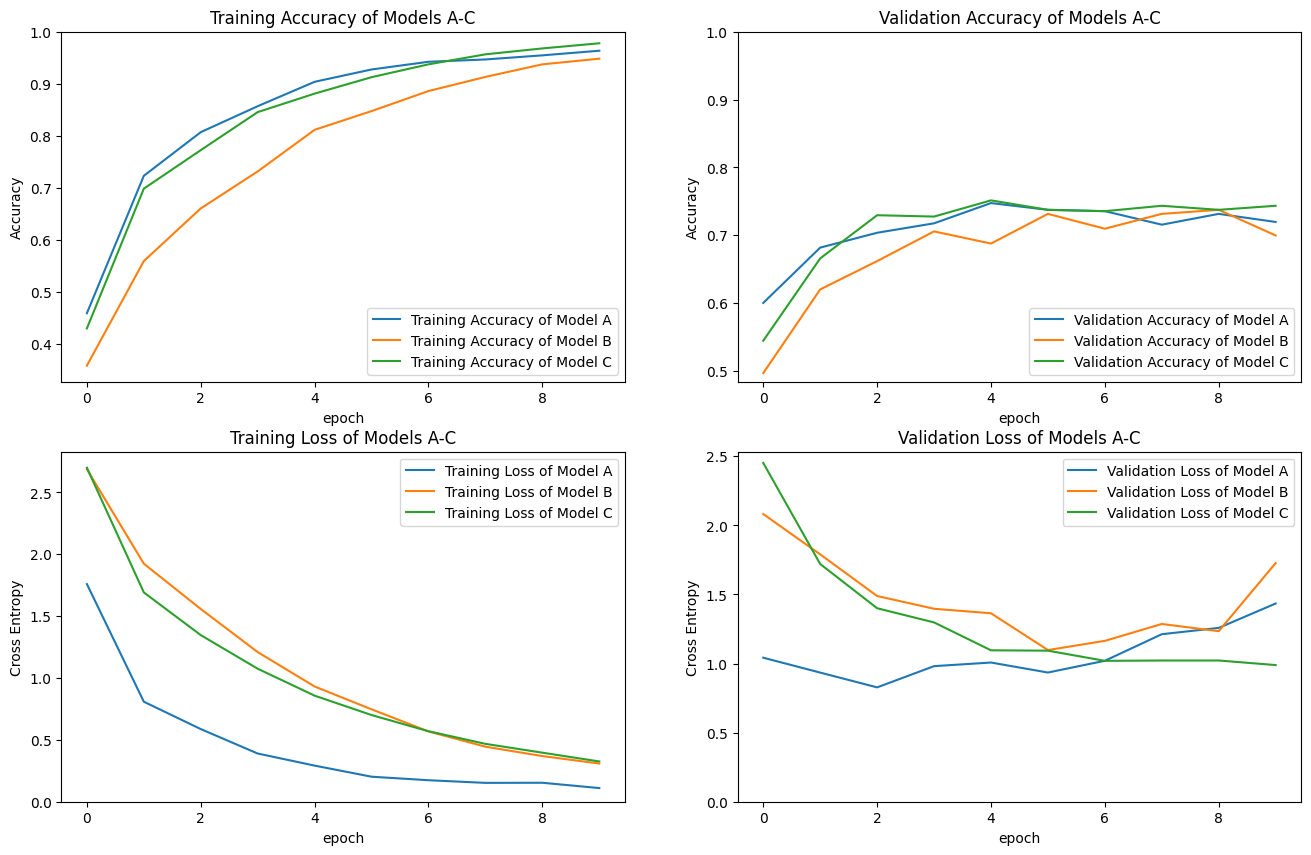

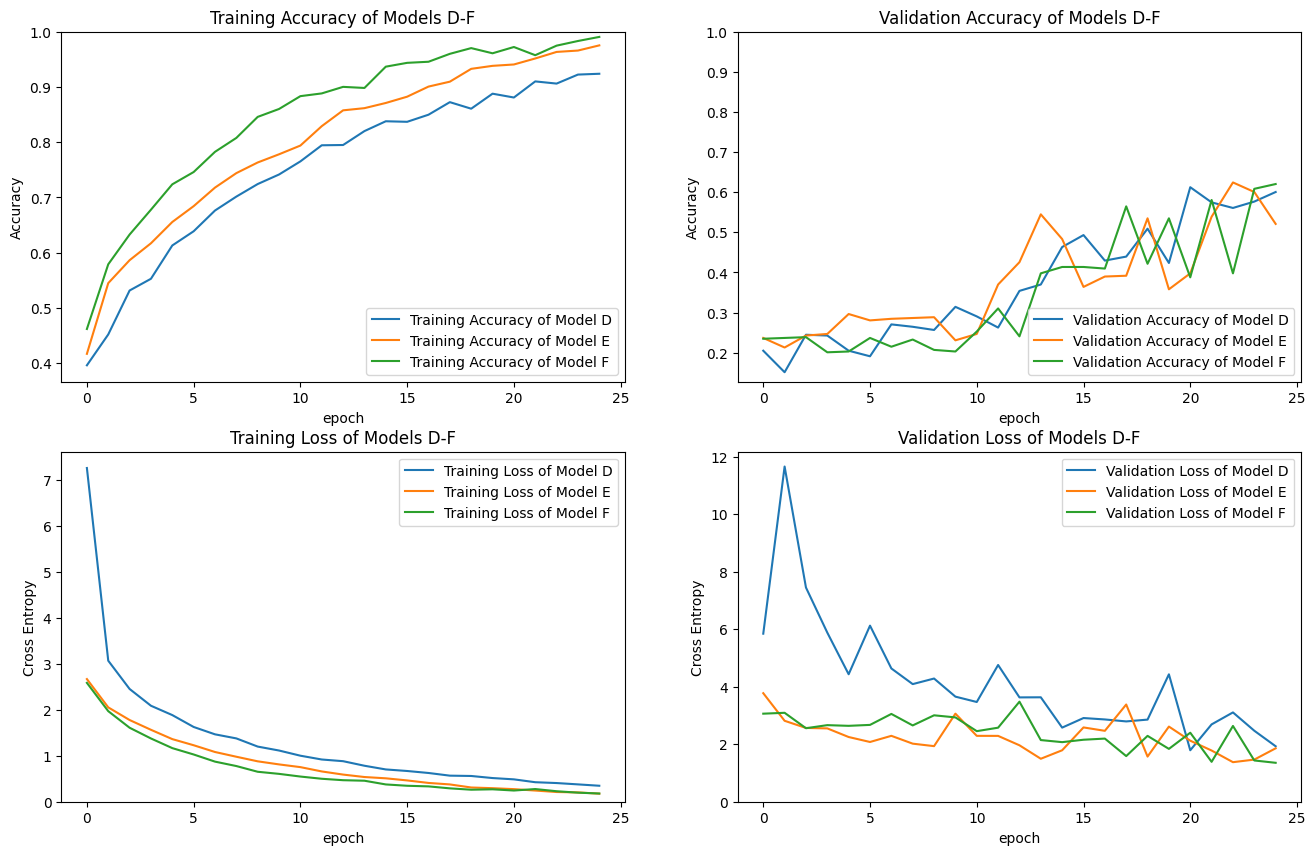

In [145]:
acc_A = historyA.history['accuracy']
val_acc_A = historyA.history['val_accuracy']

loss_A = historyA.history['loss']
val_loss_A = historyA.history['val_loss']

acc_B = historyB.history['accuracy']
val_acc_B = historyB.history['val_accuracy']

loss_B = historyB.history['loss']
val_loss_B = historyB.history['val_loss']

acc_C = historyC.history['accuracy']
val_acc_C = historyC.history['val_accuracy']

loss_C = historyC.history['loss']
val_loss_C = historyC.history['val_loss']

acc_D = historyD.history['accuracy']
val_acc_D = historyD.history['val_accuracy']

loss_D = historyD.history['loss']
val_loss_D = historyD.history['val_loss']

acc_E = historyE.history['accuracy']
val_acc_E = historyE.history['val_accuracy']

loss_E = historyE.history['loss']
val_loss_E = historyE.history['val_loss']

acc_F = historyF.history['accuracy']
val_acc_F = historyF.history['val_accuracy']

loss_F = historyF.history['loss']
val_loss_F = historyF.history['val_loss']

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(acc_A, label='Training Accuracy of Model A')
plt.plot(acc_B, label='Training Accuracy of Model B')
plt.plot(acc_C, label='Training Accuracy of Model C')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy of Models A-C')

plt.subplot(2, 2, 2)
plt.plot(val_acc_A, label='Validation Accuracy of Model A')
plt.plot(val_acc_B, label='Validation Accuracy of Model B')
plt.plot(val_acc_C, label='Validation Accuracy of Model C')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy of Models A-C')

plt.subplot(2, 2, 3)
plt.plot(loss_A, label='Training Loss of Model A')
plt.plot(loss_B, label='Training Loss of Model B')
plt.plot(loss_C, label='Training Loss of Model C')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss of Models A-C')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(val_loss_A, label='Validation Loss of Model A')
plt.plot(val_loss_B, label='Validation Loss of Model B')
plt.plot(val_loss_C, label='Validation Loss of Model C')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Validation Loss of Models A-C')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(acc_D, label='Training Accuracy of Model D')
plt.plot(acc_E, label='Training Accuracy of Model E')
plt.plot(acc_F, label='Training Accuracy of Model F')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy of Models D-F')

plt.subplot(2, 2, 2)
plt.plot(val_acc_D, label='Validation Accuracy of Model D')
plt.plot(val_acc_E, label='Validation Accuracy of Model E')
plt.plot(val_acc_F, label='Validation Accuracy of Model F')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy of Models D-F')

plt.subplot(2, 2, 3)
plt.plot(loss_D, label='Training Loss of Model D')
plt.plot(loss_E, label='Training Loss of Model E')
plt.plot(loss_F, label='Training Loss of Model F')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss of Models D-F')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(val_loss_D, label='Validation Loss of Model D')
plt.plot(val_loss_E, label='Validation Loss of Model E')
plt.plot(val_loss_F, label='Validation Loss of Model F')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Validation Loss of Models D-F')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model for Models A, B and C


After training classification layers, we wanted to study if training the weights of the pre-trained network weren't initially changed could further boost classification accuracy

### Un-freeze more layers


We first check many layers are in the base model

In [146]:
print("Number of layers in the base model: ", len(base_model_MNV2.layers))

Number of layers in the base model:  154


Let's try freezing just the bottom 50 layers.

In [147]:
base_model_MNV2.trainable = True
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_MNV2.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

Now configure the model again, but this time with a lower learning rate (the default is 0.001).

In [57]:
modelA.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelB.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
modelC.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
print("Model A Architecture:")
modelA.summary()
print("Model B Architecture:")
modelB.summary()
print("Model C Architecture:")
modelC.summary()
print("Model D Architecture:")
modelD.summary()
print("Model E Architecture:")
modelE.summary()
print("Model F Architecture:")
modelF.summary()

Model A Architecture:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 3, 3, 32)       │     1,024,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │         1,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,283,750 (12.53 MB)

 Trainable params: 3,200,358 (12.21 MB)

 Non-trainable params: 83,392 (325.75 KB)

Model B Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 3, 3, 32)       │     1,024,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,327,654 (12.69 MB)

 Trainable params: 3,244,262 (12.38 MB)

 Non-trainable params: 83,392 (325.75 KB)

Model C Architecture:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 32)       │       163,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 2, 2, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435,046 (9.29 MB)

 Trainable params: 2,351,462 (8.97 MB)

 Non-trainable params: 83,584 (326.50 KB)

Model D Architecture:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 107, 107, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 107, 107, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 47, 47, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,345,396 (50.91 MB)

 Trainable params: 4,448,390 (16.97 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 8,896,782 (33.94 MB)

Model E Architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 105, 105, 64)   │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 105, 105, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 52, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 42, 42, 128)    │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │     3,612,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,119,188 (53.86 MB)

 Trainable params: 4,706,246 (17.95 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 9,412,494 (35.91 MB)

Model F Architecture:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 6, 6, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 6, 6, 128)      │           51

 Total params: 3,362,612 (12.83 MB)

 Trainable params: 1,120,326 (4.27 MB)

 Non-trainable params: 1,632 (6.38 KB)

 Optimizer params: 2,240,654 (8.55 MB)

In [184]:
print('Number of trainable layers = {}'.format(len(modelA.trainable_weights)))
print('Number of trainable layers = {}'.format(len(modelB.trainable_weights)))
print('Number of trainable layers = {}'.format(len(modelC.trainable_weights)))
print('Number of trainable layers = {}'.format(len(modelD.trainable_weights)))
print('Number of trainable layers = {}'.format(len(modelE.trainable_weights)))
print('Number of trainable layers = {}'.format(len(modelF.trainable_weights)))

Number of trainable layers = 109
Number of trainable layers = 113
Number of trainable layers = 117
Number of trainable layers = 16
Number of trainable layers = 20
Number of trainable layers = 38


### Continue training

In our 2nd training run, we fine-tune all trainable layers, including the lower layers of the base model. Since we are starting with the weights already trained in the classification layers during the first training run, we reduce the amount of epochs to 5

In [60]:
history_fine_A = modelA.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6613 - loss: 1.6495 - val_accuracy: 0.7217 - val_loss: 1.3573
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.7512 - loss: 0.8098 - val_accuracy: 0.7316 - val_loss: 1.3257
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - accuracy: 0.8103 - loss: 0.5701 - val_accuracy: 0.7296 - val_loss: 1.2909
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.8464 - loss: 0.4437 - val_accuracy: 0.7296 - val_loss: 1.2857
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.8705 - loss: 0.3633 - val_accuracy: 0.7256 - val_loss: 1.2981


In [61]:
history_fine_B = modelB.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7384 - loss: 1.0524 - val_accuracy: 0.7018 - val_loss: 1.7020
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.8370 - loss: 0.6360 - val_accuracy: 0.7038 - val_loss: 1.6238
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 421ms/step - accuracy: 0.8670 - loss: 0.5198 - val_accuracy: 0.7078 - val_loss: 1.6043
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.8867 - loss: 0.4573 - val_accuracy: 0.7058 - val_loss: 1.6233
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 408ms/step - accuracy: 0.9025 - loss: 0.4451 - val_accuracy: 0.7038 - val_loss: 1.6132


In [62]:
history_fine_C = modelC.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8376 - loss: 0.7073 - val_accuracy: 0.7475 - val_loss: 1.0006
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.8565 - loss: 0.6242 - val_accuracy: 0.7515 - val_loss: 1.0252
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 430ms/step - accuracy: 0.9001 - loss: 0.5176 - val_accuracy: 0.7495 - val_loss: 1.0267
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.9041 - loss: 0.4837 - val_accuracy: 0.7515 - val_loss: 1.0336
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 407ms/step - accuracy: 0.9284 - loss: 0.4443 - val_accuracy: 0.7475 - val_loss: 1.0313


### Review the new learning curves

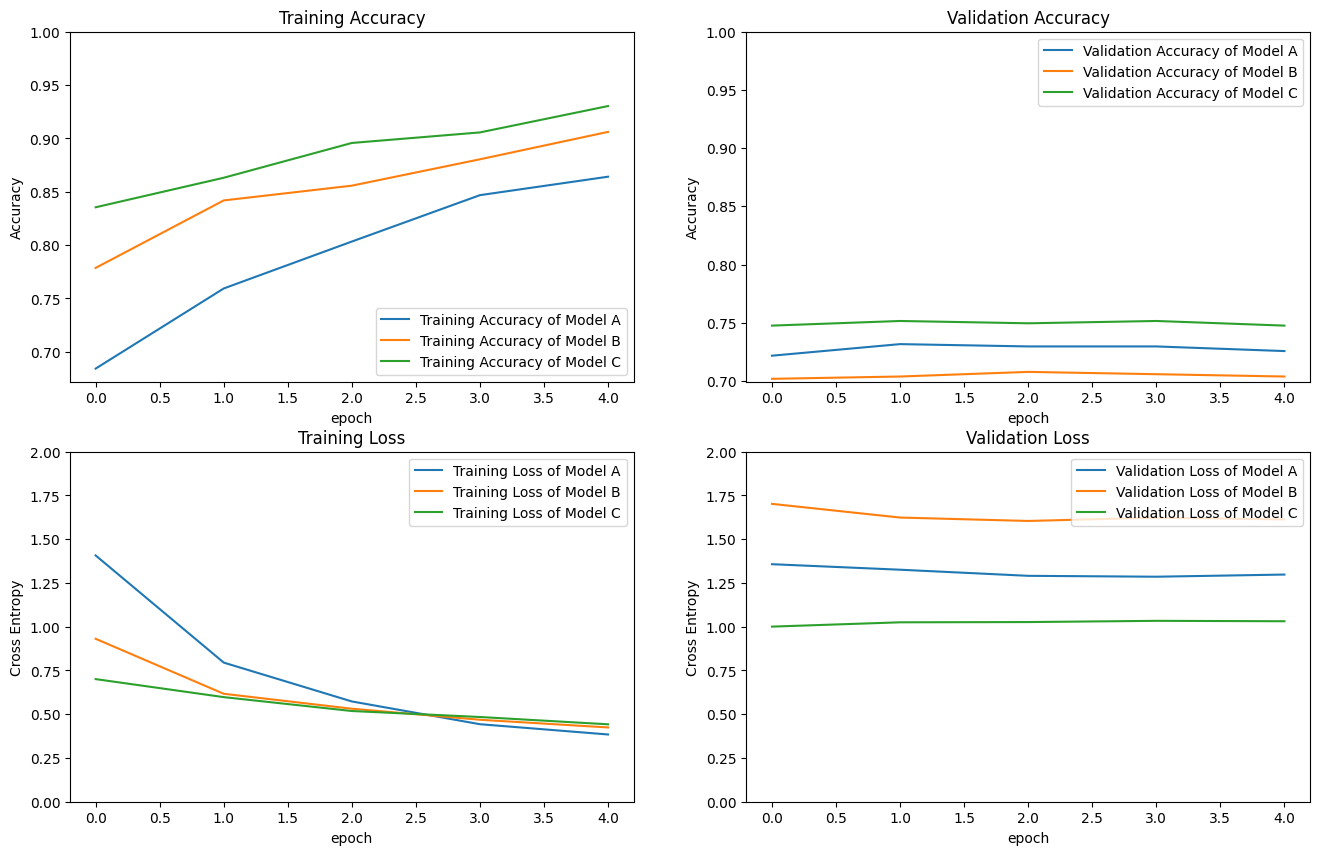

In [148]:
acc_A = history_fine_A.history['accuracy']
val_acc_A = history_fine_A.history['val_accuracy']

loss_A = history_fine_A.history['loss']
val_loss_A = history_fine_A.history['val_loss']

acc_B = history_fine_B.history['accuracy']
val_acc_B = history_fine_B.history['val_accuracy']

loss_B = history_fine_B.history['loss']
val_loss_B = history_fine_B.history['val_loss']

acc_C = history_fine_C.history['accuracy']
val_acc_C = history_fine_C.history['val_accuracy']

loss_C = history_fine_C.history['loss']
val_loss_C = history_fine_C.history['val_loss']

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(acc_A, label='Training Accuracy of Model A')
plt.plot(acc_B, label='Training Accuracy of Model B')
plt.plot(acc_C, label='Training Accuracy of Model C')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(val_acc_A, label='Validation Accuracy of Model A')
plt.plot(val_acc_B, label='Validation Accuracy of Model B')
plt.plot(val_acc_C, label='Validation Accuracy of Model C')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(loss_A, label='Training Loss of Model A')
plt.plot(loss_B, label='Training Loss of Model B')
plt.plot(loss_C, label='Training Loss of Model C')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(val_loss_A, label='Validation Loss of Model A')
plt.plot(val_loss_B, label='Validation Loss of Model B')
plt.plot(val_loss_C, label='Validation Loss of Model C')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

As shown, validation loss is still greater than training loss, which might indicate some overfitting. More importantly, it seems that fine-tuning does not improve validation accuracy by much if at all, indicating the base pre-trained model already generalized well to different classes of garbage image data.

## Convert to TFLite

We need to perform post-training quantization of the model to int8 format, we need to perform [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) with a representative dataset, which requires a few more arguments for the `TFLiteConverter`, and a function that builds a dataset that's representative of the training dataset. This function is the same one used in 'Retrain MobileNet V2 classifier for the Edge TPU (TF2)' Google Colab Notebook Tutorial provided by Google Coral.

In [149]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(data_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter_A = tf.lite.TFLiteConverter.from_keras_model(modelA)
converter_B = tf.lite.TFLiteConverter.from_keras_model(modelB)
converter_C = tf.lite.TFLiteConverter.from_keras_model(modelC)
converter_D = tf.lite.TFLiteConverter.from_keras_model(modelD)
converter_E = tf.lite.TFLiteConverter.from_keras_model(modelE)
converter_F = tf.lite.TFLiteConverter.from_keras_model(modelF)

# This enables quantization
converter_A.optimizations = [tf.lite.Optimize.DEFAULT]
converter_B.optimizations = [tf.lite.Optimize.DEFAULT]
converter_C.optimizations = [tf.lite.Optimize.DEFAULT]
converter_D.optimizations = [tf.lite.Optimize.DEFAULT]
converter_E.optimizations = [tf.lite.Optimize.DEFAULT]
converter_F.optimizations = [tf.lite.Optimize.DEFAULT]

# This sets the representative dataset for quantization
converter_A.representative_dataset = representative_data_gen
converter_B.representative_dataset = representative_data_gen
converter_C.representative_dataset = representative_data_gen
converter_D.representative_dataset = representative_data_gen
converter_E.representative_dataset = representative_data_gen
converter_F.representative_dataset = representative_data_gen

# This ensures that if any ops can't be quantized, the converter throws an error
converter_A.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_B.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_C.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_D.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_E.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_F.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter_A.target_spec.supported_types = [tf.int8]
converter_B.target_spec.supported_types = [tf.int8]
converter_C.target_spec.supported_types = [tf.int8]
converter_D.target_spec.supported_types = [tf.int8]
converter_E.target_spec.supported_types = [tf.int8]
converter_F.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter_A.inference_input_type = tf.uint8
converter_A.inference_output_type = tf.uint8

converter_B.inference_input_type = tf.uint8
converter_B.inference_output_type = tf.uint8

converter_C.inference_input_type = tf.uint8
converter_C.inference_output_type = tf.uint8

converter_D.inference_input_type = tf.uint8
converter_D.inference_output_type = tf.uint8

converter_E.inference_input_type = tf.uint8
converter_E.inference_output_type = tf.uint8

converter_F.inference_input_type = tf.uint8
converter_F.inference_output_type = tf.uint8

tflite_model_A = converter_A.convert()
tflite_model_B = converter_B.convert()
tflite_model_C = converter_C.convert()
tflite_model_D = converter_D.convert()
tflite_model_E = converter_E.convert()
tflite_model_F = converter_F.convert()

with open('garbage_model_A.tflite', 'wb') as f:
  f.write(tflite_model_A)
with open('garbage_model_B.tflite', 'wb') as f:
  f.write(tflite_model_B)
with open('garbage_model_C.tflite', 'wb') as f:
  f.write(tflite_model_C)
with open('garbage_model_D.tflite', 'wb') as f:
  f.write(tflite_model_D)
with open('garbage_model_E.tflite', 'wb') as f:
  f.write(tflite_model_E)
with open('garbage_model_F.tflite', 'wb') as f:
  f.write(tflite_model_F)

Saved artifact at '/tmp/tmpfc60sm0_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_404')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138395031208592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208288208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383942082

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmpzin03yji'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_410')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138395031208592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208288208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383942082

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmprgmkna60'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_420')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138395031208592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138395031208976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208287248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208288208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394208285712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383942082

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmp8v21312x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_644')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138397585667088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138397585667280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394905849744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394906991824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394905852048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394905848784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394906990480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394906991248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394906991632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138394906984528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383949069

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmpq58nlgd_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_661')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138387006059728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006058576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006058000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006058960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006059920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006058384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006056464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006056080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006056848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138387006057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383870060

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmp652_v8m4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_680')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138386898033680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898035216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898035408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898034640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898033104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898035024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898036944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898037520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898037712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138386898036560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383868980

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


### Compare the accuracy


After fully quantizing the 6 TensorFlow Lite models, we evaluate both the raw model and the TensorFlow Lite model to ensure minimala accuracy drop pre and post quantization

The test accuracy of the raw models are shown below, for a randomly selected test data batch from the dataset

In [180]:
batch_images, batch_labels = next(val_generator)

logitsA = modelA(batch_images)
predictionA = np.argmax(logitsA, axis=1)
logitsB = modelB(batch_images)
predictionB = np.argmax(logitsB, axis=1)
logitsC = modelC(batch_images)
predictionC = np.argmax(logitsC, axis=1)
logitsD = modelD(batch_images)
predictionD = np.argmax(logitsD, axis=1)
logitsE = modelE(batch_images)
predictionE = np.argmax(logitsE, axis=1)
logitsF = modelF(batch_images)
predictionF = np.argmax(logitsF, axis=1)

truth = np.argmax(batch_labels, axis=1)

keras_accuracy_A = tf.keras.metrics.Accuracy()
keras_accuracy_A(predictionA, truth)
keras_accuracy_B = tf.keras.metrics.Accuracy()
keras_accuracy_B(predictionB, truth)
keras_accuracy_C = tf.keras.metrics.Accuracy()
keras_accuracy_C(predictionC, truth)
keras_accuracy_D = tf.keras.metrics.Accuracy()
keras_accuracy_D(predictionD, truth)
keras_accuracy_E = tf.keras.metrics.Accuracy()
keras_accuracy_E(predictionE, truth)
keras_accuracy_F = tf.keras.metrics.Accuracy()
keras_accuracy_F(predictionF, truth)

print("Raw model A accuracy: {:.3%}".format(keras_accuracy_A.result()))
print("Raw model B accuracy: {:.3%}".format(keras_accuracy_B.result()))
print("Raw model C accuracy: {:.3%}".format(keras_accuracy_C.result()))
print("Raw model D accuracy: {:.3%}".format(keras_accuracy_D.result()))
print("Raw model E accuracy: {:.3%}".format(keras_accuracy_E.result()))
print("Raw model F accuracy: {:.3%}".format(keras_accuracy_F.result()))

Raw model A accuracy: 68.750%
Raw model B accuracy: 70.312%
Raw model C accuracy: 73.438%
Raw model D accuracy: 60.938%
Raw model E accuracy: 60.938%
Raw model F accuracy: 75.000%


We now check the accuracy of the `.tflite` quantized model, using the test data batch

Since there was no convenient API to evaluate the accuracy of a TensorFlow Lite model, in the 'Retrain MobileNet V2 classifier for the Edge TPU (TF2)' tutorial Colab Notebook provided by Google Coral, set_input_tensor() and classify_image() functions were provided to run several inferences and compare the predictions against ground truth:

In [182]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreterA = tf.lite.Interpreter('garbage_model_A.tflite')
interpreterA.allocate_tensors()
interpreterB = tf.lite.Interpreter('garbage_model_B.tflite')
interpreterB.allocate_tensors()
interpreterC = tf.lite.Interpreter('garbage_model_C.tflite')
interpreterC.allocate_tensors()
interpreterD = tf.lite.Interpreter('garbage_model_D.tflite')
interpreterD.allocate_tensors()
interpreterE = tf.lite.Interpreter('garbage_model_E.tflite')
interpreterE.allocate_tensors()
interpreterF = tf.lite.Interpreter('garbage_model_E.tflite')
interpreterF.allocate_tensors()
# Collect all inference predictions in a list
batch_prediction_A = []
batch_prediction_B = []
batch_prediction_C = []
batch_prediction_D = []
batch_prediction_E = []
batch_prediction_F = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction_A = classify_image(interpreterA, batch_images[i])
  prediction_B = classify_image(interpreterB, batch_images[i])
  prediction_C = classify_image(interpreterC, batch_images[i])
  prediction_D = classify_image(interpreterD, batch_images[i])
  prediction_E = classify_image(interpreterE, batch_images[i])
  prediction_F = classify_image(interpreterF, batch_images[i])
  batch_prediction_A.append(prediction_A)
  batch_prediction_B.append(prediction_B)
  batch_prediction_C.append(prediction_C)
  batch_prediction_D.append(prediction_D)
  batch_prediction_E.append(prediction_E)
  batch_prediction_F.append(prediction_F)

# Compare all predictions to the ground truth
tflite_model_A_accuracy = tf.keras.metrics.Accuracy()
tflite_model_B_accuracy = tf.keras.metrics.Accuracy()
tflite_model_C_accuracy = tf.keras.metrics.Accuracy()
tflite_model_D_accuracy = tf.keras.metrics.Accuracy()
tflite_model_E_accuracy = tf.keras.metrics.Accuracy()
tflite_model_F_accuracy = tf.keras.metrics.Accuracy()

tflite_model_A_accuracy(batch_prediction_A, batch_truth)
tflite_model_B_accuracy(batch_prediction_B, batch_truth)
tflite_model_C_accuracy(batch_prediction_C, batch_truth)
tflite_model_D_accuracy(batch_prediction_D, batch_truth)
tflite_model_E_accuracy(batch_prediction_E, batch_truth)
tflite_model_F_accuracy(batch_prediction_F, batch_truth)

print("Quantized Model A TF Lite accuracy: {:.3%}".format(tflite_model_A_accuracy.result()))
print("Quantized Model B TF Lite accuracy: {:.3%}".format(tflite_model_B_accuracy.result()))
print("Quantized Model C TF Lite accuracy: {:.3%}".format(tflite_model_C_accuracy.result()))
print("Quantized Model D TF Lite accuracy: {:.3%}".format(tflite_model_D_accuracy.result()))
print("Quantized Model E TF Lite accuracy: {:.3%}".format(tflite_model_E_accuracy.result()))
print("Quantized Model F TF Lite accuracy: {:.3%}".format(tflite_model_F_accuracy.result()))

Quantized Model A TF Lite accuracy: 71.875%
Quantized Model B TF Lite accuracy: 68.750%
Quantized Model C TF Lite accuracy: 73.438%
Quantized Model D TF Lite accuracy: 59.375%
Quantized Model E TF Lite accuracy: 60.938%
Quantized Model F TF Lite accuracy: 60.938%


As shown, there is typically little to moderate difference in the testing accuracy between pre- and post-quantization models

## Compile for the Edge TPU


We compile the models for the Edge TPU., first by downloading the [Edge TPU Compiler](https://coral.ai/docs/edgetpu/compiler/):

In [79]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  13319      0 --:--:-- --:--:-- --:--:-- 13447
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [1,423 B]
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable/main all Packages [1,865 B]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [6,888 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubunt

Then we check the workign directory to ensure correct paths

In [80]:
cwd = os.getcwd()
print("Current working directory:", cwd)
os.chdir('/content/drive/My Drive/ELEN 6350/6908 Dataset')
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/.shortcut-targets-by-id/1ZwkGtzXqT581LVQ7k4uaz4vuI_P6pQEq/ELEN 6350/6908 Dataset
Current working directory: /content/drive/.shortcut-targets-by-id/1ZwkGtzXqT581LVQ7k4uaz4vuI_P6pQEq/ELEN 6350/6908 Dataset


We then compile the models one-by-one

In [154]:
! edgetpu_compiler 'garbage_model_A.tflite'


Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1197 ms.

Input model: garbage_model_A.tflite
Input size: 3.56MiB
Output model: garbage_model_A_edgetpu.tflite
Output size: 3.75MiB
On-chip memory used for caching model parameters: 4.60MiB
On-chip memory remaining for caching model parameters: 3.09MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 68
Operation log: garbage_model_A_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [155]:
! edgetpu_compiler 'garbage_model_B.tflite'


Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1997 ms.

Input model: garbage_model_B.tflite
Input size: 3.61MiB
Output model: garbage_model_B_edgetpu.tflite
Output size: 3.79MiB
On-chip memory used for caching model parameters: 4.63MiB
On-chip memory remaining for caching model parameters: 3.06MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 70
Operation log: garbage_model_B_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [156]:
! edgetpu_compiler 'garbage_model_C.tflite'


Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1143 ms.

Input model: garbage_model_C.tflite
Input size: 2.76MiB
Output model: garbage_model_C_edgetpu.tflite
Output size: 2.95MiB
On-chip memory used for caching model parameters: 2.96MiB
On-chip memory remaining for caching model parameters: 4.73MiB
Off-chip memory used for streaming uncached model parameters: 3.00KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 76
Operation log: garbage_model_C_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [157]:
! edgetpu_compiler 'garbage_model_D.tflite'


Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 769 ms.

Input model: garbage_model_D.tflite
Input size: 4.26MiB
Output model: garbage_model_D_edgetpu.tflite
Output size: 4.36MiB
On-chip memory used for caching model parameters: 137.75KiB
On-chip memory remaining for caching model parameters: 4.51MiB
Off-chip memory used for streaming uncached model parameters: 4.14MiB
Number of Edge TPU subgraphs: 1
Total number of operations: 18
Operation log: garbage_model_D_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [174]:
! edgetpu_compiler 'garbage_model_E.tflite'


Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.
Compilation child process completed within timeout period.
Compilation failed! 


In [169]:
! edgetpu_compiler 'garbage_model_F.tflite'

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 433 ms.

Input model: garbage_model_F.tflite
Input size: 1.10MiB
Output model: garbage_model_F_edgetpu.tflite
Output size: 1.25MiB
On-chip memory used for caching model parameters: 1.09MiB
On-chip memory remaining for caching model parameters: 3.56MiB
Off-chip memory used for streaming uncached model parameters: 21.50KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 35
Operation log: garbage_model_F_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


All models except for Model E were sucessfully compiled. We could not debug why compilation failed for Model E, so it is skipped for the actualy model testing on the device

## Download the model

Dowwnload the 5 successfuly compiled TFLite models

In [185]:
from google.colab import files

files.download('garbage_model_A_edgetpu.tflite')
files.download('garbage_model_B_edgetpu.tflite')
files.download('garbage_model_C_edgetpu.tflite')
files.download('garbage_model_D_edgetpu.tflite')
files.download('garbage_model_F_edgetpu.tflite')
files.download('garbage_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the model on the Edge TPU




You can now run the model on your Coral device with acceleration on the Edge TPU.

To get started, try using your `.tflite` model with [this code for image classification with the TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification).

Just follow the instructions on that page to set up your device, copy the `mobilenet_v2_1.0_224_quant_edgetpu.tflite` and `flower_labels.txt` files to your Coral Dev Board or device with a Coral Accelerator, and pass it a flower photo like this:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels flower_labels.txt \
  --input flower.jpg
```

Check out more examples for running inference at [coral.ai/examples](https://coral.ai/examples/#code-examples/).